## AAUtoSig Markdown
This document is a runthrough of our autoencoder model.
Firstly we initialise our installed packages

In [14]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp

from random import sample
from itertools import permutations

## Initialise the autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model.

In [15]:
class NMFAE(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        # Building an linear encoder
        # 96 => dim1
        self.enc1 = torch.nn.Linear(1536, dim1, bias = False)
          
        # Building an linear decoder 
        # dim1 ==> 96
        self.dec1 = torch.nn.Linear(dim1, 1536, bias = False)
            

    def forward(self, x):
        x = self.enc1(x)
        x = self.dec1(x)
        return x
        
    # Model Initialization
                                
def train_NMFAE(epochs, model, x_train, loss_function, optimizer, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    for _ in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)


          optimizer.zero_grad() #clear old gradients
          loss.backward() #backpropagation
          optimizer.step() #update params
        #constrain the weights of the decoding layer to be non-negative  
        with torch.no_grad():
            for p in model.dec1.weight:
                p.clamp_(min = 0)
        
    return(model)

# Useful functions
plotsigs plots an array of signatures.

In [16]:
def plotsigs(context, mutation, signatures, nsigs, title):
    colors = {'C>A': 'r', 'C>G': 'b', 'C>T': 'g', 
                'T>A' : 'y', 'T>C': 'c','T>G' : 'm' }
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    for i in range(nsigs):
        plt.subplot(nsigs,1, (i+1))
        #plt.figure(figsize=(20,7))
        plt.bar(x = context, 
                height =  signatures[:,i]/np.sum(signatures[:,i]), 
                color = [colors[i] for i in mutation])
        plt.xticks([])
        if i == 0:
            plt.title(title)
    #plt.legend(handles,labels)
    #plt.xticks(rotation=90)
    plt.show()


## Application
Now we can use our autoencoder on some simulated data

In [17]:
nsigs = 5

mf_df = pd.read_csv(r'WGS_PCAWG.1536.csv')
penta = mf_df['Pentanucleotide']
mutation = mf_df['Mutation type']
mf_df = mf_df.drop(['Pentanucleotide', 'Mutation type'], axis = 1)
X = mf_df.transpose()

#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model = NMFAE(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
                            
train_NMFAE(epochs = 500, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size=16)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

In [18]:
tri = [p[1] +"[" + m + "]" + p[3] for (m,p) in zip(mutation,penta)]
 
sigs['Mutation type'] = mutation
sigs['Trinucleotide'] = tri
sigs['Pentanucleotide'] = penta
sigs

sigs96 = pd.DataFrame(sigs.groupby('Trinucleotide').sum())
sigs96['Mutation'] = [s[2:5] for s in sigs96.index]
sigs96 = sigs96.sort_values('Mutation')
trinucleotide = sigs96.index
mutation = sigs96['Mutation']
sigs96 = sigs96.drop('Mutation', axis = 1)

sigs96

,0,1,2,3,4
Trinucleotide,,,,,
A[C>A]A,0.110284,0.075496,0.000000,0.033155,0.060299
C[C>A]T,0.443963,0.126717,0.085997,0.010222,1.559114
C[C>A]G,0.028360,0.017872,0.000000,0.005892,0.087536
C[C>A]C,0.086358,0.073682,0.000000,0.025010,0.283364
C[C>A]A,0.156760,0.112664,0.000000,0.044495,0.248416
...,...,...,...,...,...
A[T>G]G,0.010232,0.001379,0.000117,0.007003,0.022526
A[T>G]C,0.021326,0.002737,0.011646,0.002205,0.066171
A[T>G]A,0.080785,0.007542,0.000000,0.012797,0.012946


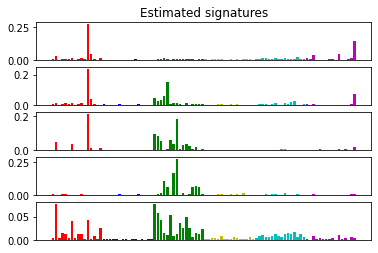

In [19]:
#plot the results
plotsigs(trinucleotide, mutation, sigs96.to_numpy(), nsigs, "Estimated signatures")  


Det  her ser selvfølgelig lidt fjollet ud, men det er også fordi vi har forsøgt at beskrive hele PCAWG med 5 signaturer. Men det er sådan her metoden fungerer